[2025-08-12 13:25:50,404] [ WARNING] surya.py:27 - Could not import Surya dependencies (layout and/or table_rec): No module named 'surya.common'


Processing: Abilene_Christian_University.pdf
Processing: Alabama_A&M_University.pdf
Processing: Alabama_State_University.pdf
Processing: Alcorn_State_University.pdf
Processing: American_University.pdf


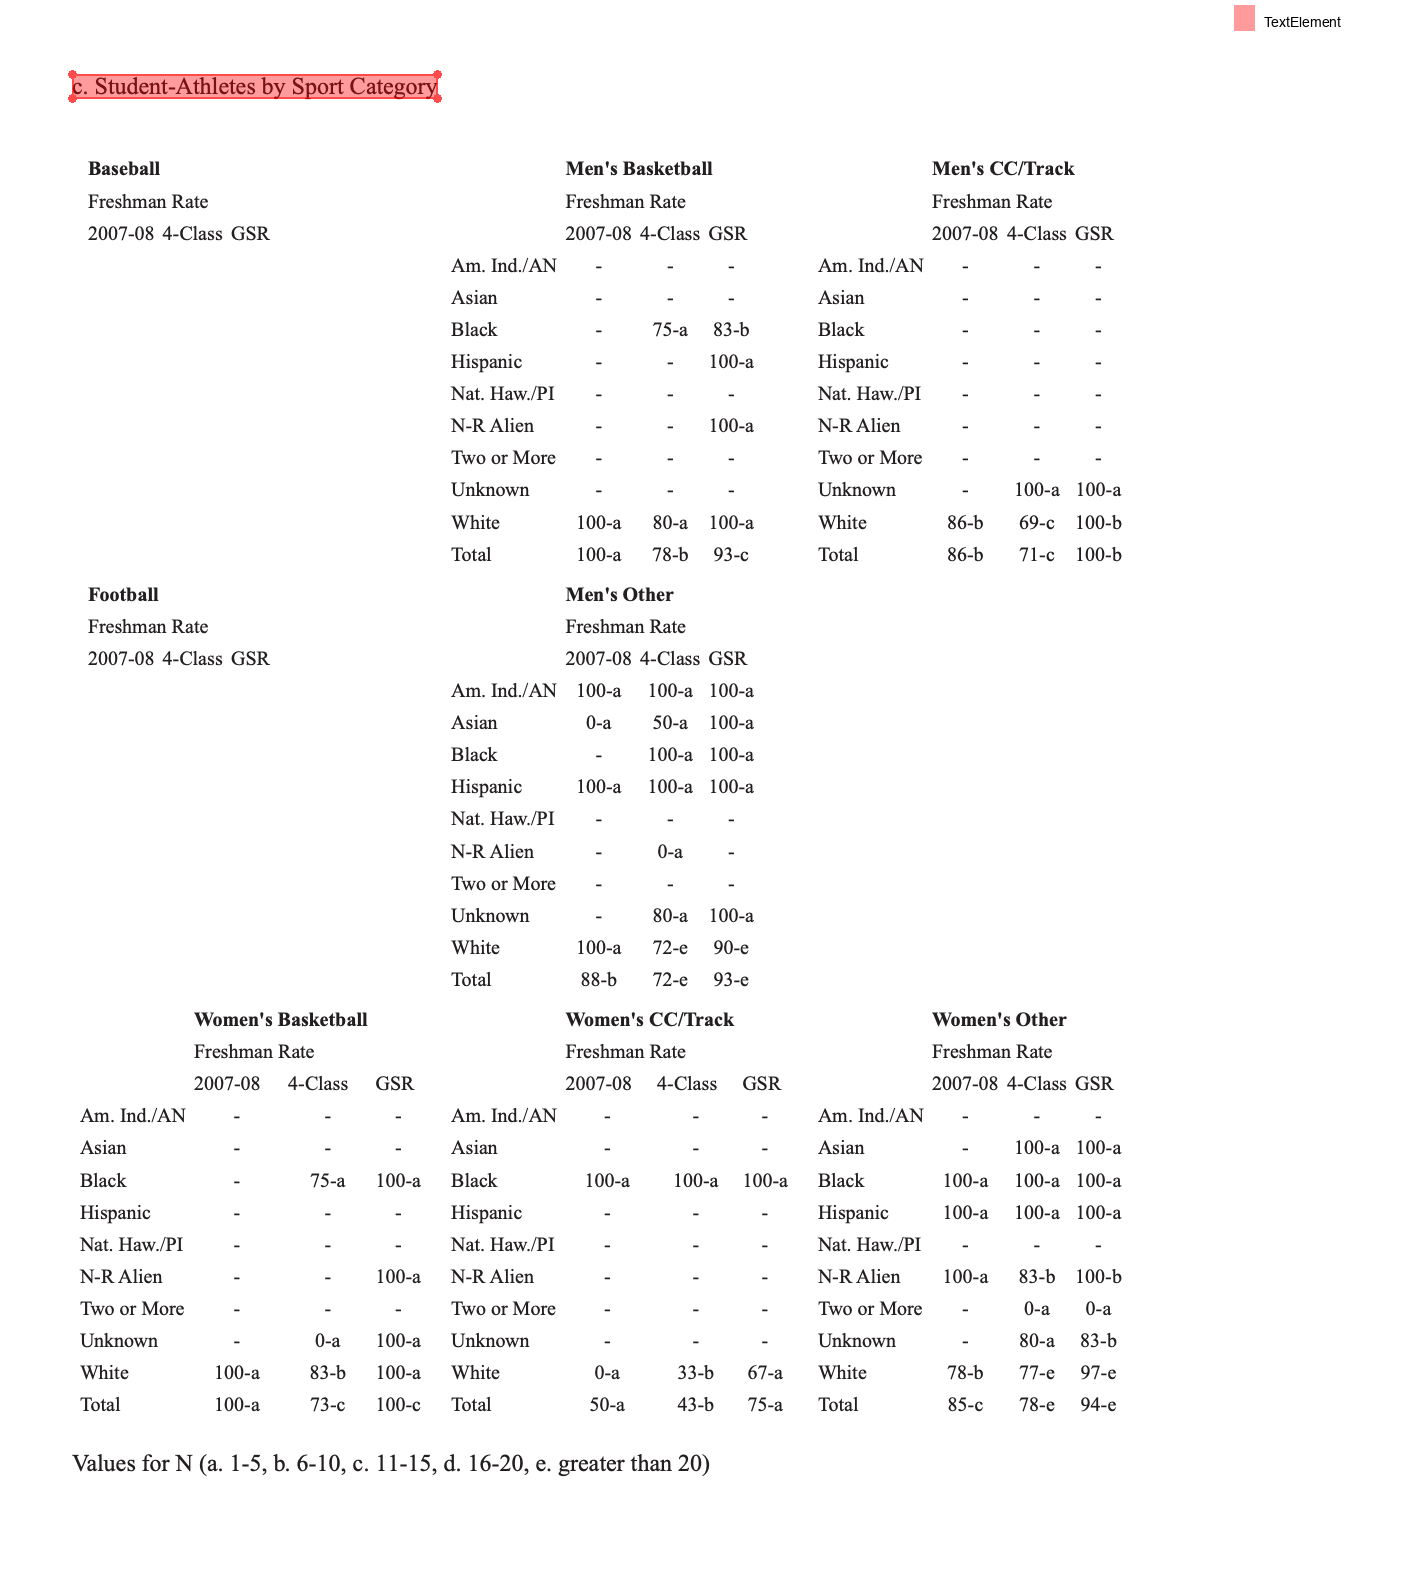

In [1]:
import os
from natural_pdf import PDF

pdf_folder = "pdfs"

pdf_files = sorted([f for f in os.listdir(pdf_folder) if f.endswith(".pdf")])[:5]

for filename in pdf_files:
    filepath = os.path.join(pdf_folder, filename)
    print(f"Processing: {filename}")
    
    pdf = PDF(filepath)
    
    if not pdf.pages:
        print("No pages found in this PDF.")
        continue
    
    page = pdf.pages[0]

page = pdf.pages[1]

page.find("text").show()

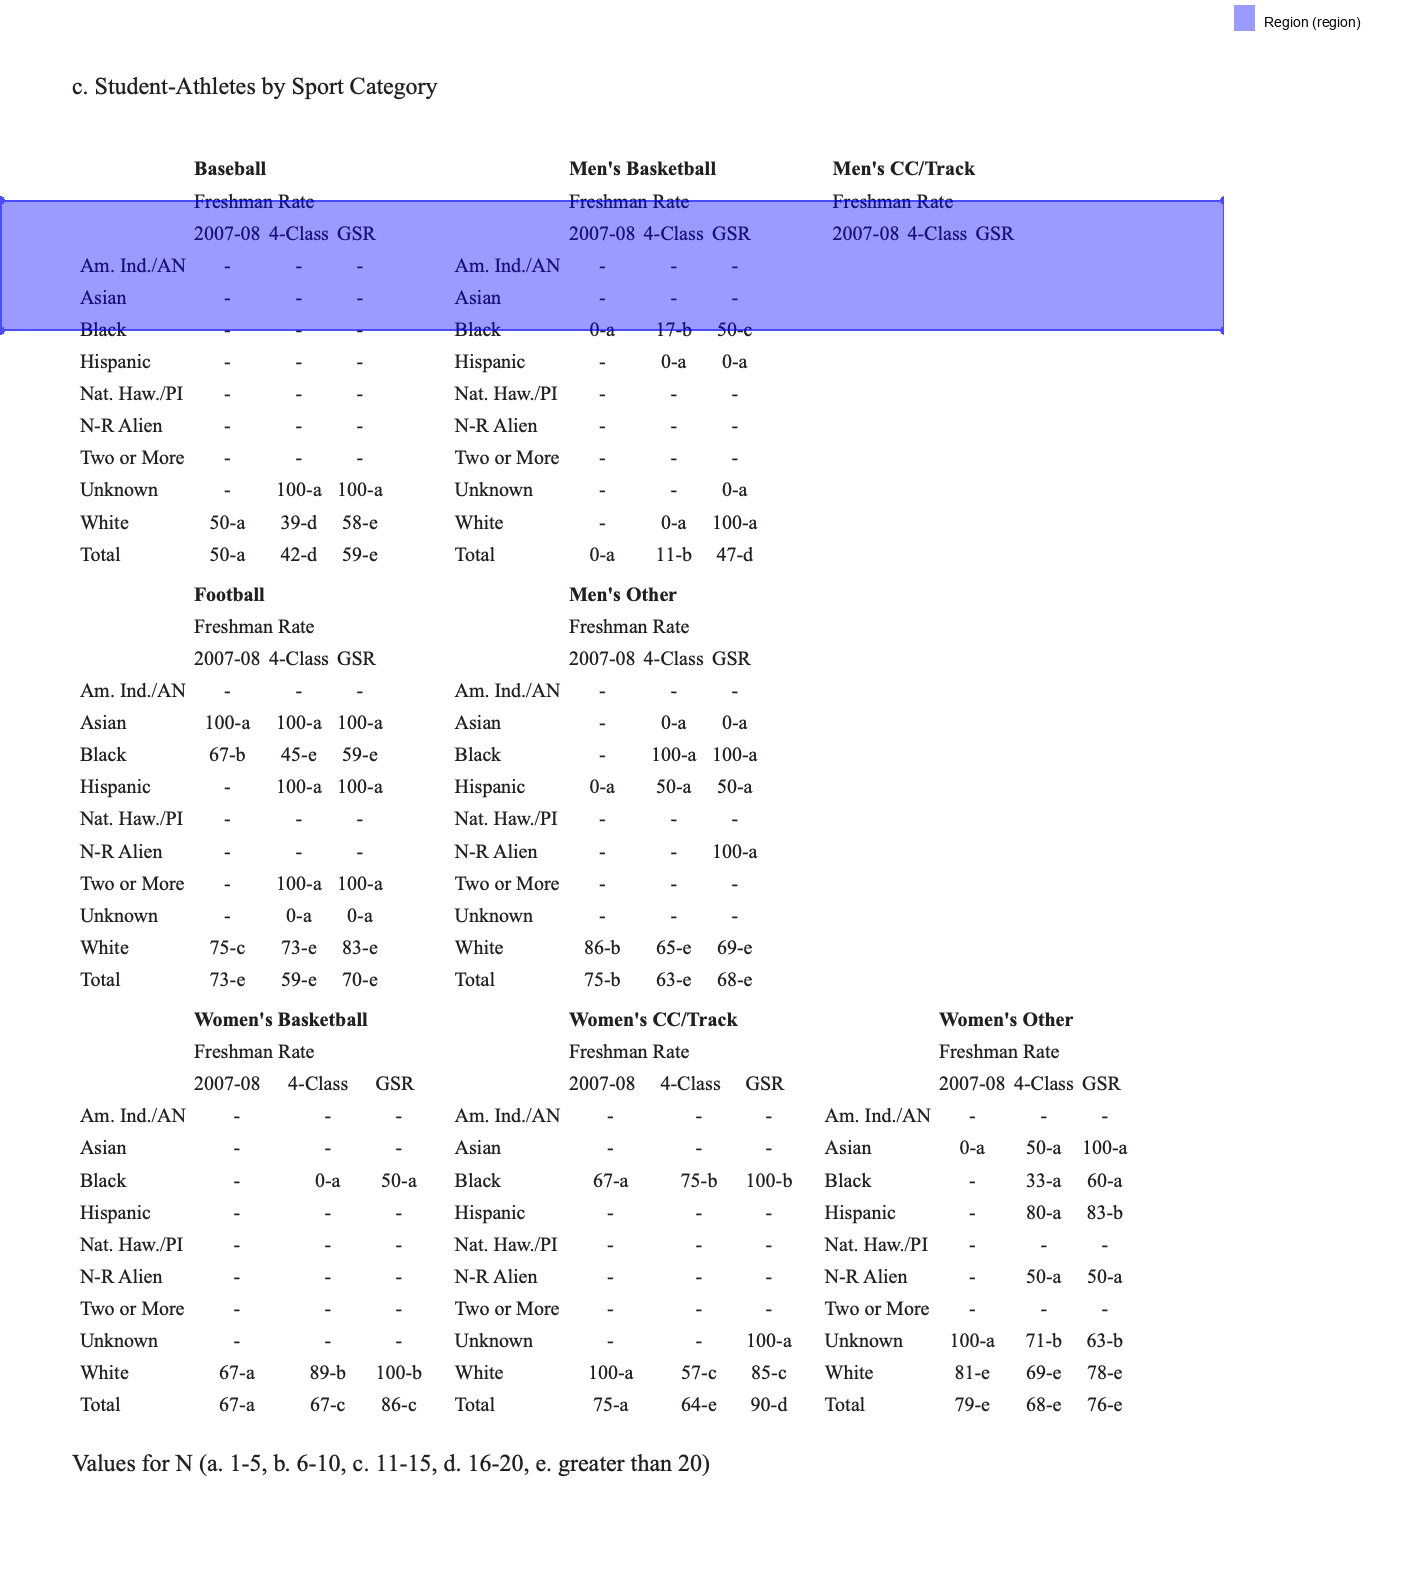

In [15]:
top_table = page.region(top=100, height=65)
top_table.show()

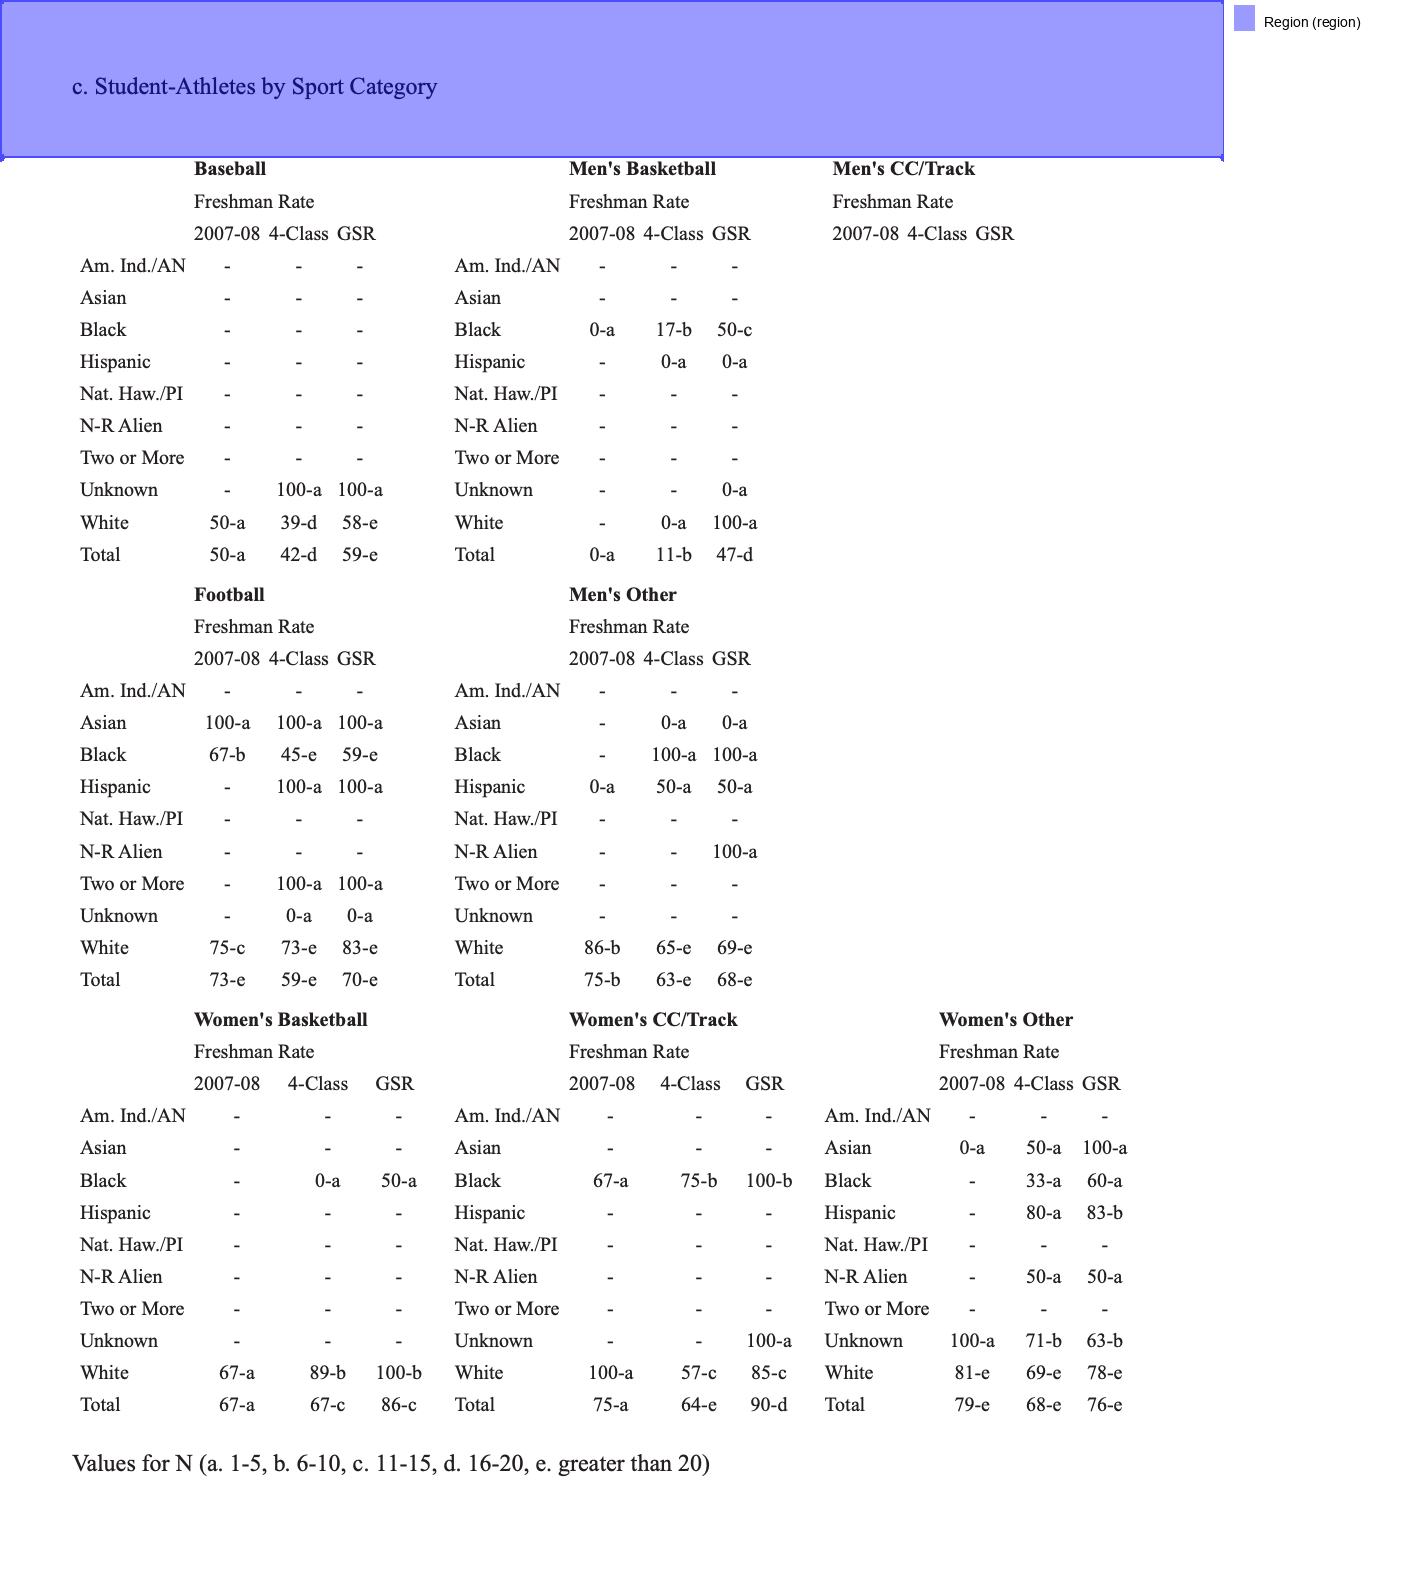

In [16]:
(
    page
    .find(text='Baseball')
    .above(until='text:contains("Football")')
    .show()
)

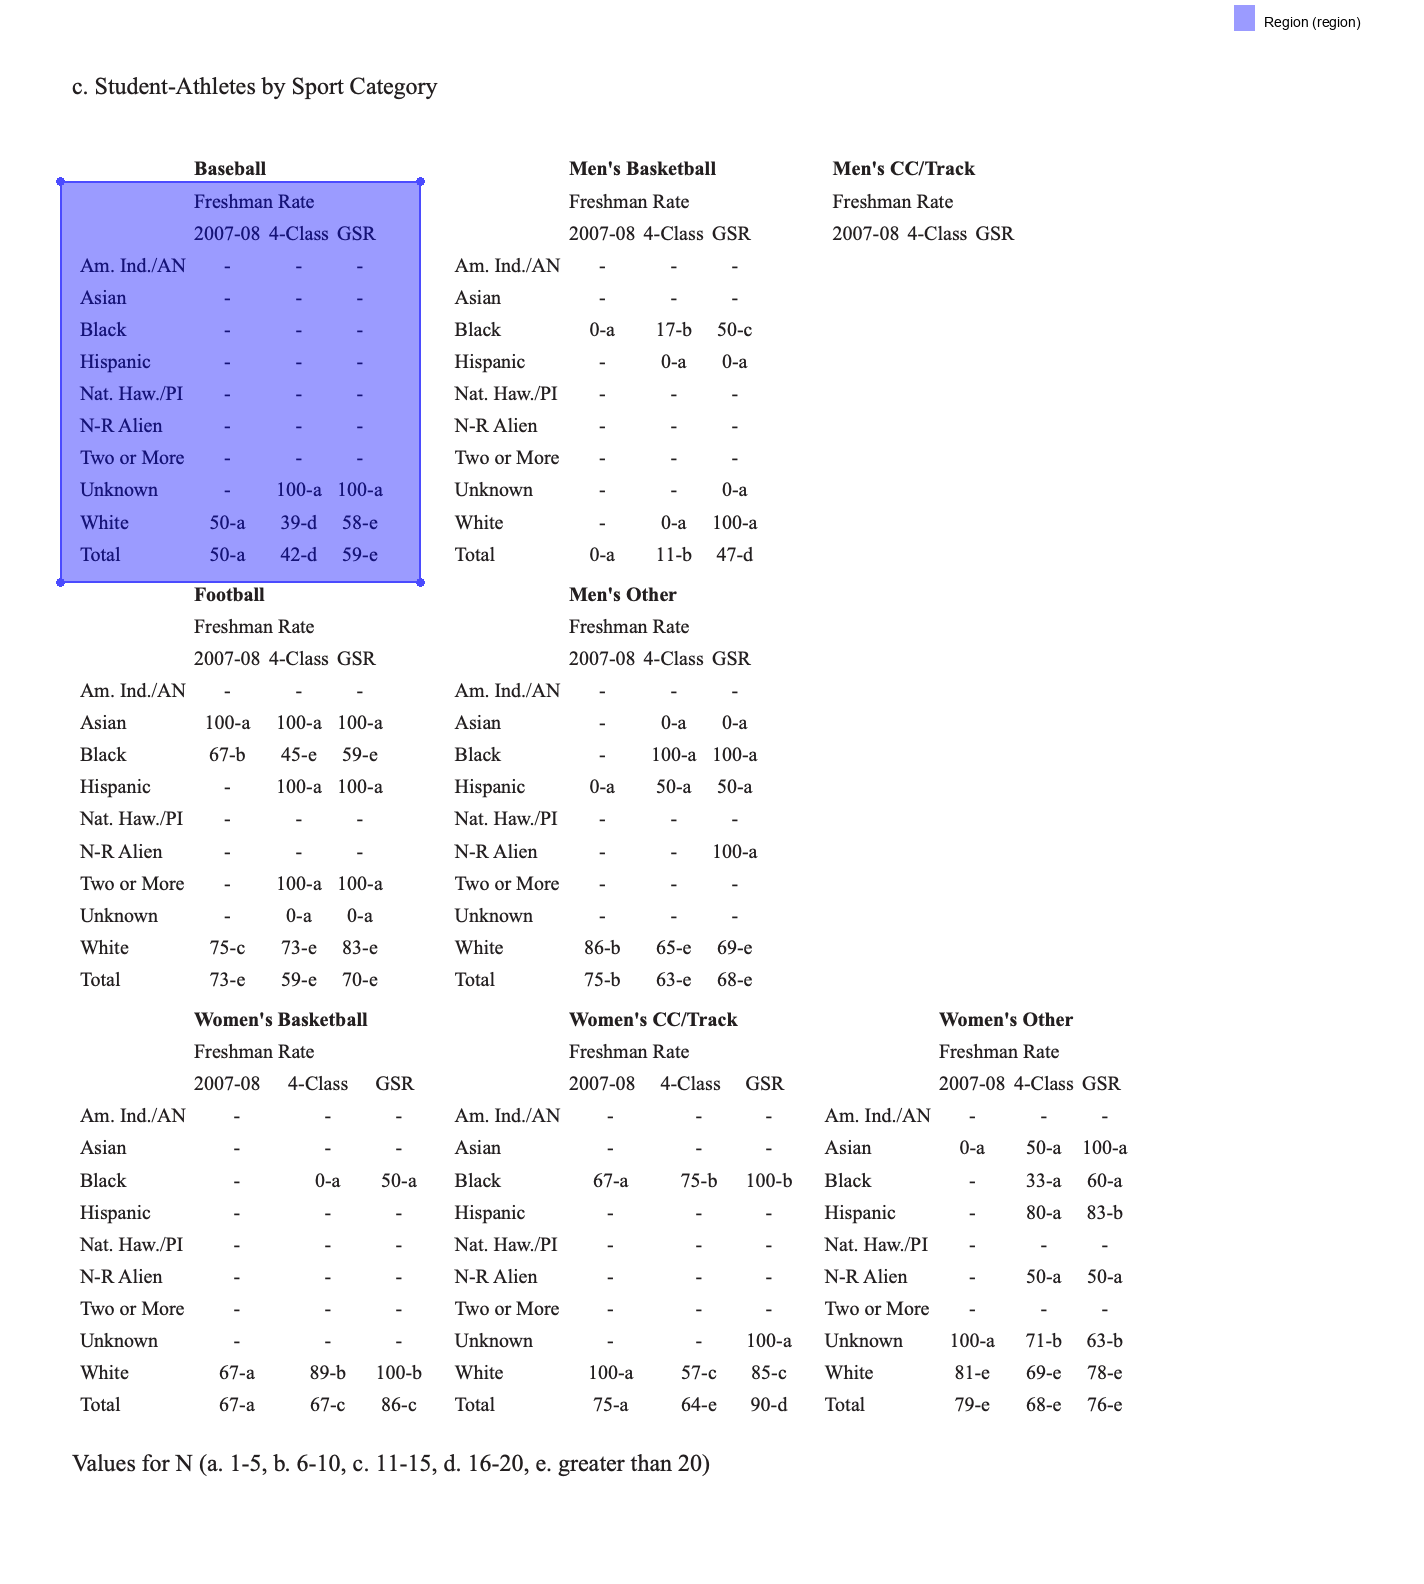

In [22]:
(
    page
    .find(text='Baseball')
    .below(
        until='text:contains("Football")',
        include_endpoint=False
    )
    .clip(left=30, right=210)
    .show()
)
#baseball

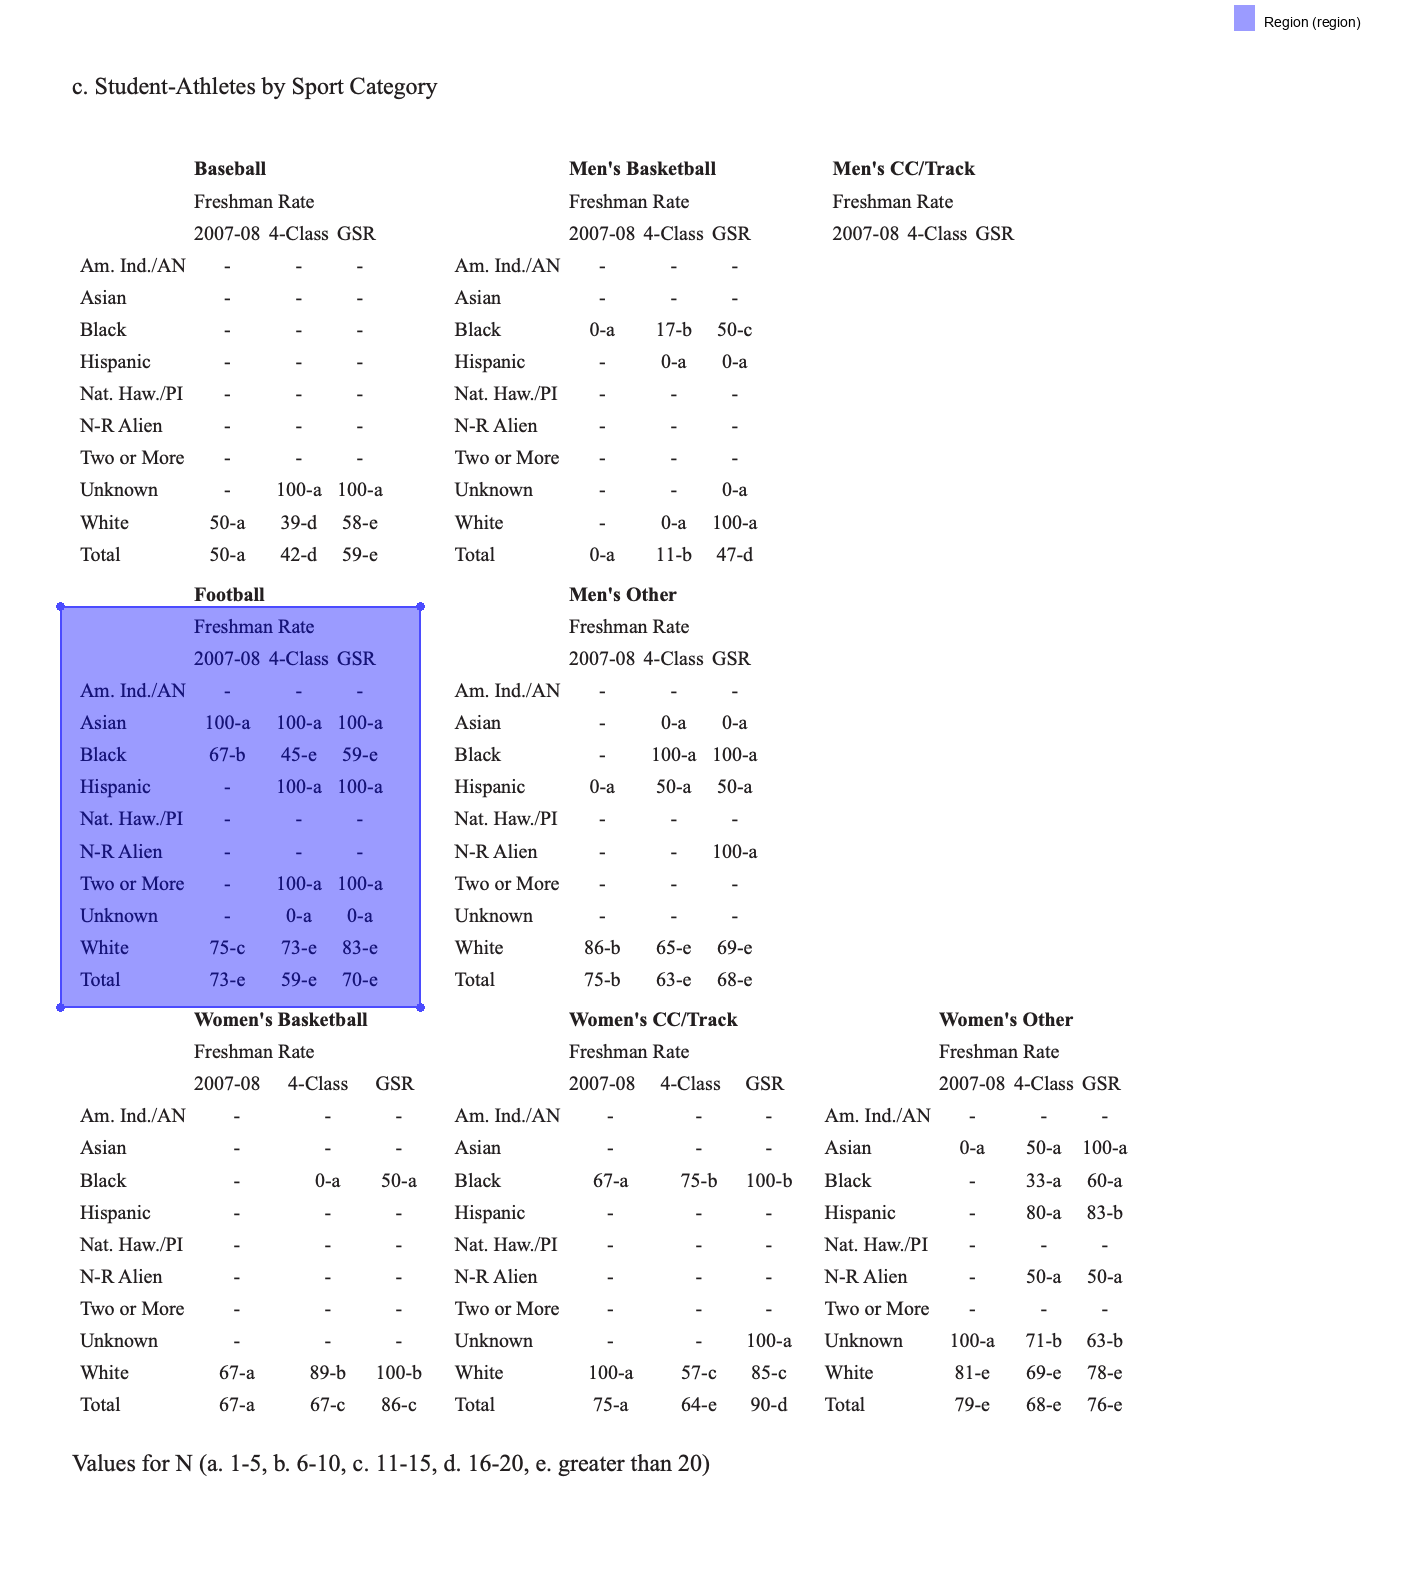

In [26]:
(
    page
    .find(text='Football')
    .below(
        until="text:contains(\"Women's Basketball\")",
        include_endpoint=False
    )
    .clip(left=30, right=210)
    .show()
)
#Football

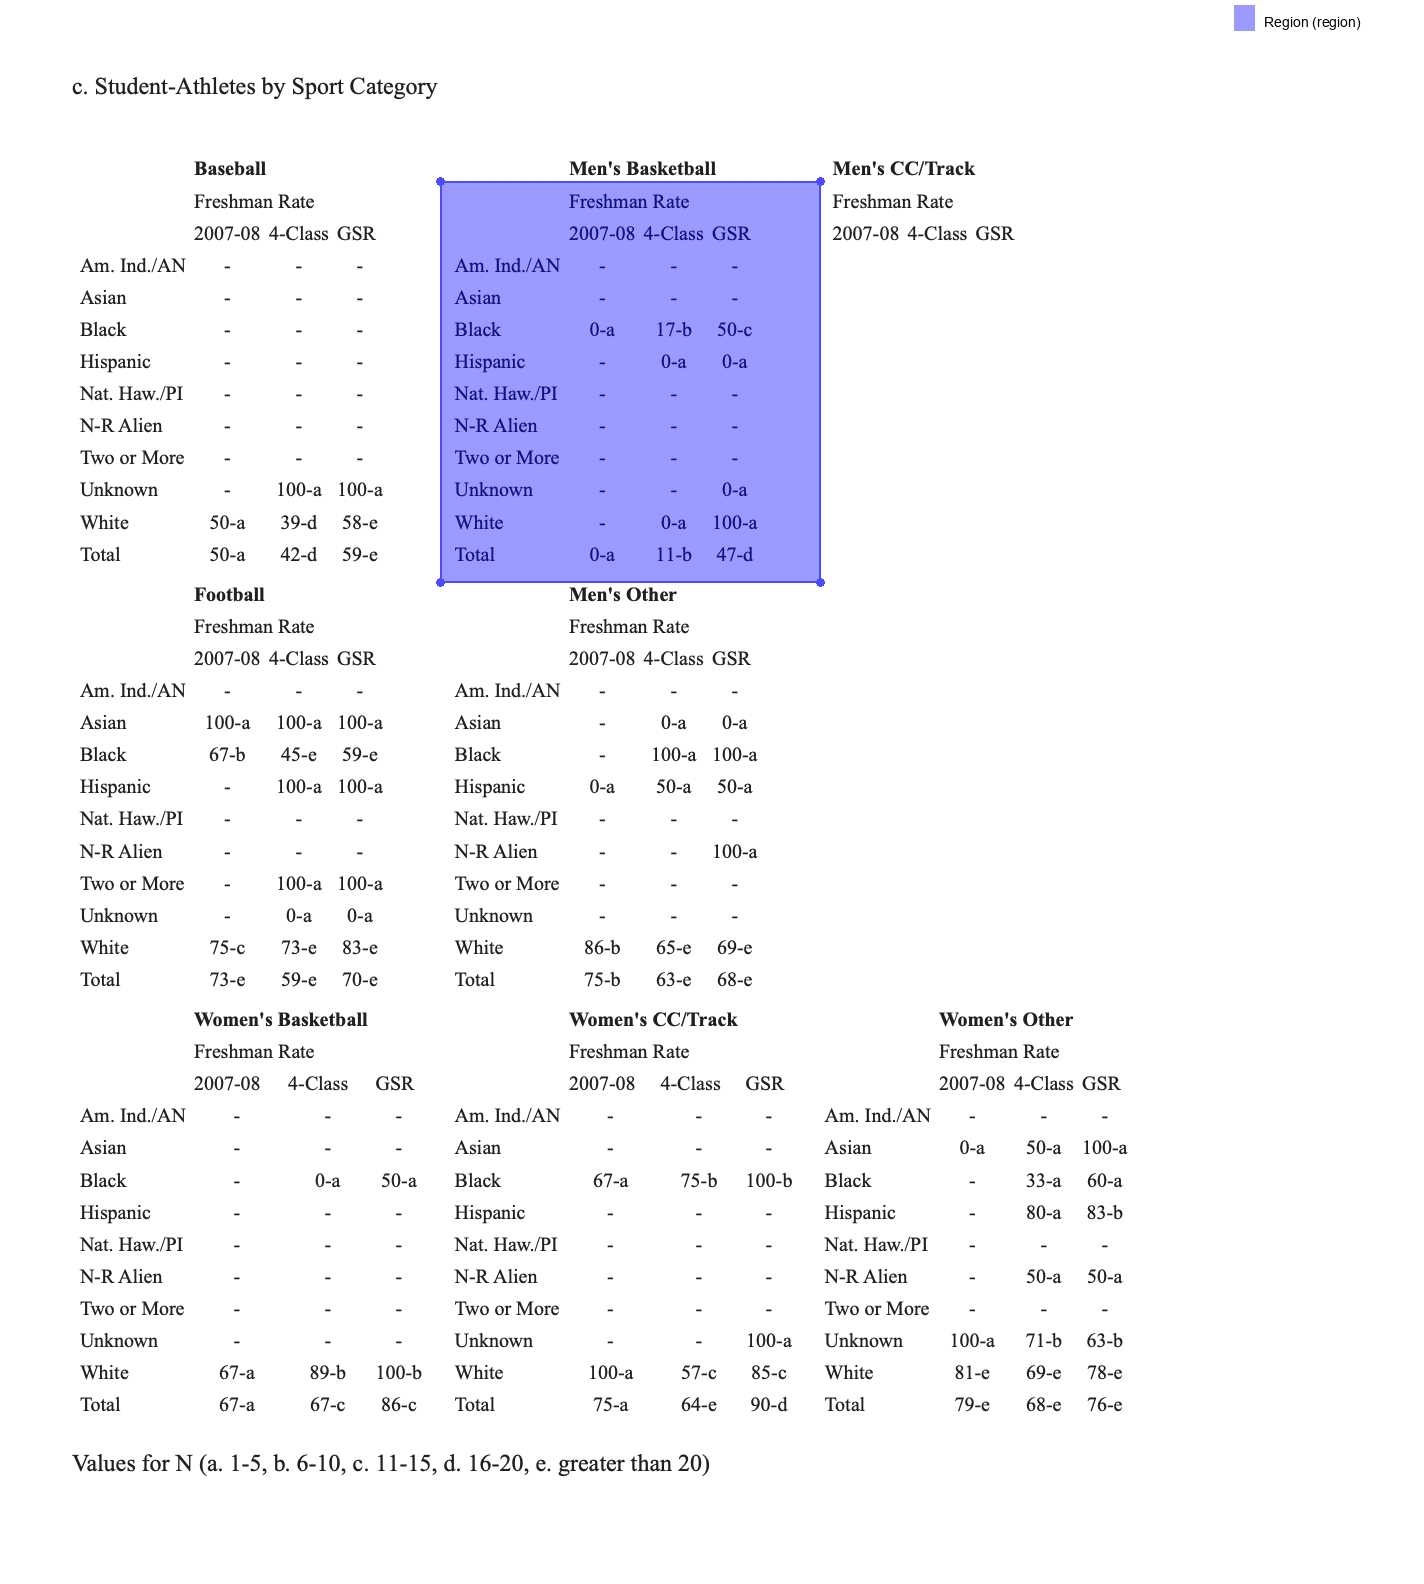

In [29]:
(
    page
    .find("text:contains(\"Men's Basketball\")")
    .below(
        until="text:contains(\"Men's Other\")",
        include_endpoint=False
    )
    .clip(left=220, right=410)
    .show()
)
#MenBasketball

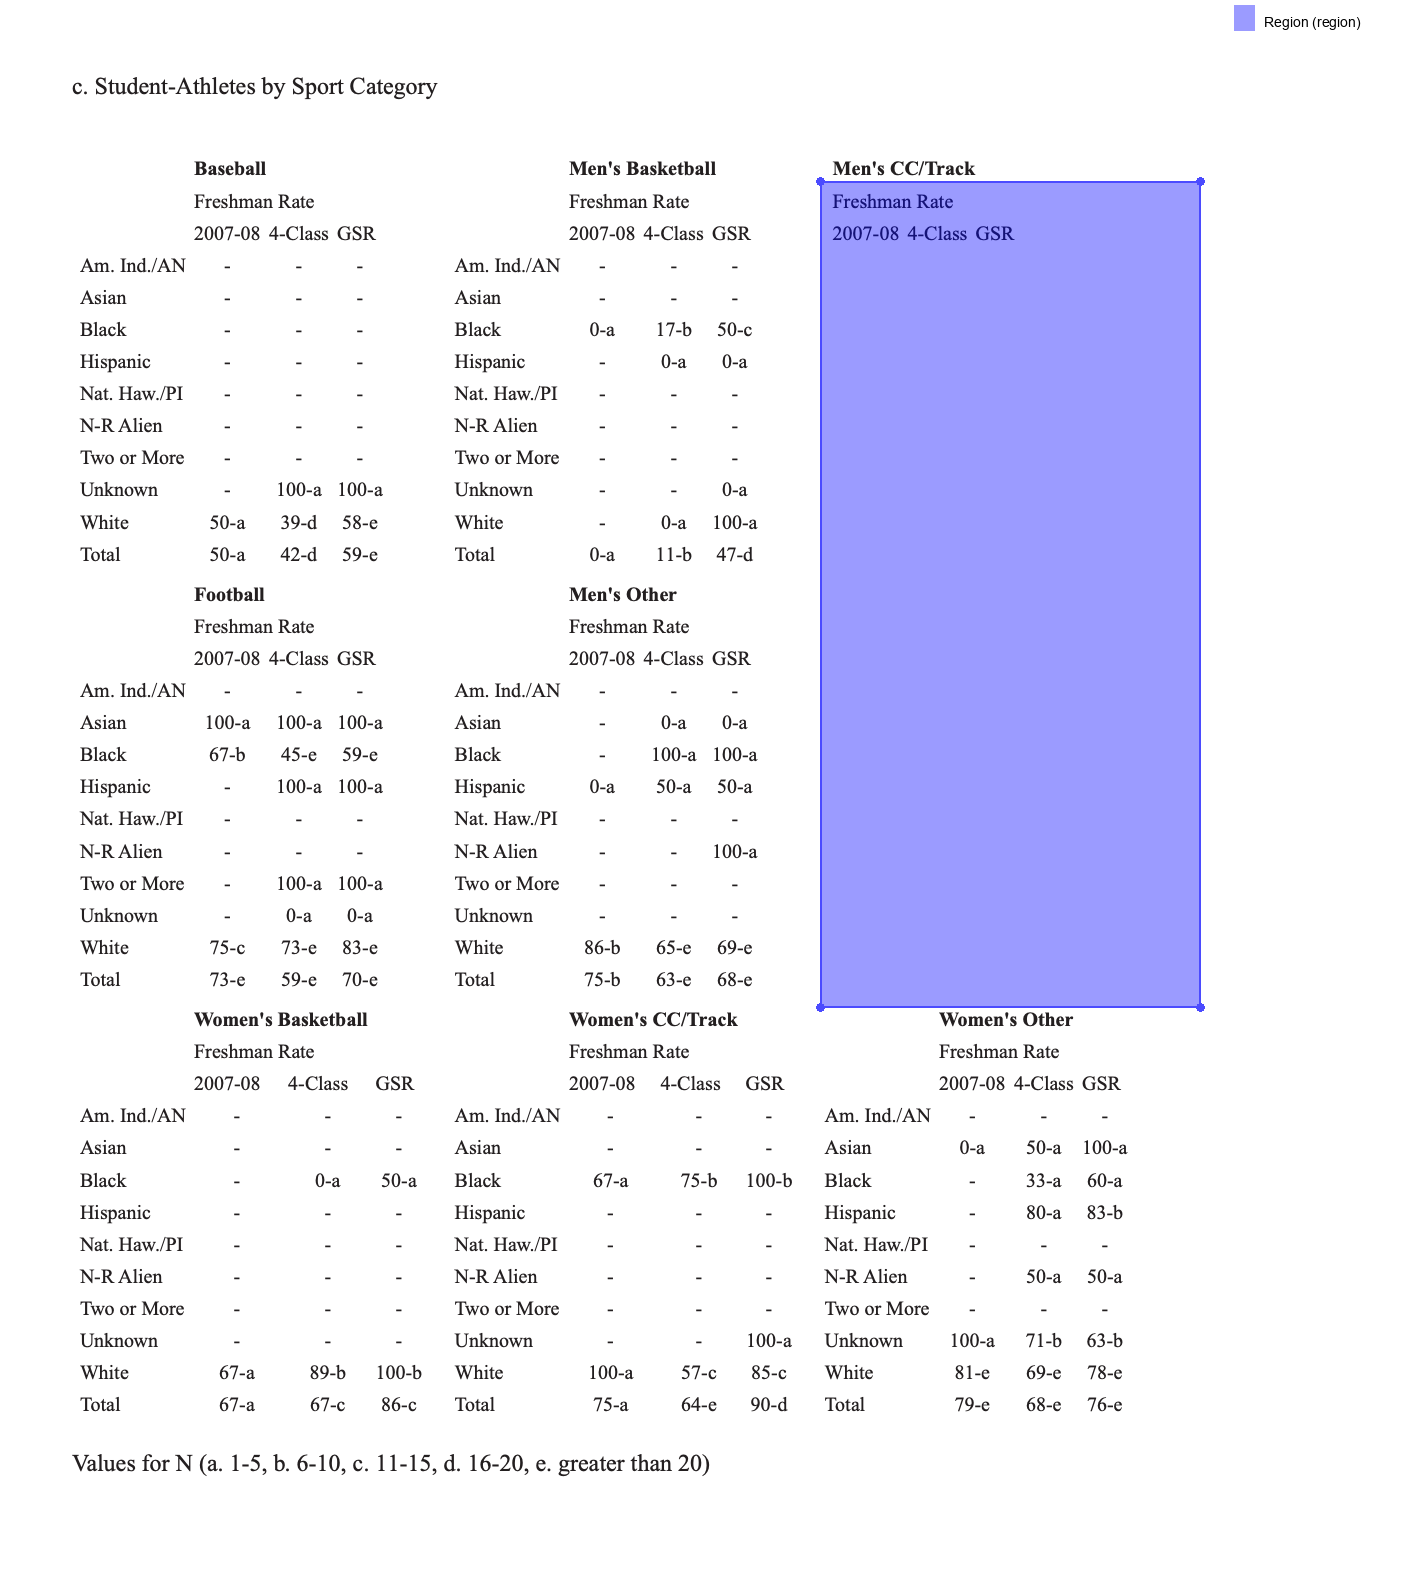

In [31]:
(
    page
    .find("text:contains(\"Men's CC\")")
    .below(
        until="text:contains(\"Women's Other\")",
        include_endpoint=False
    )
    .clip(left=410, right=600)
    .show()
)
#MenCC/Track

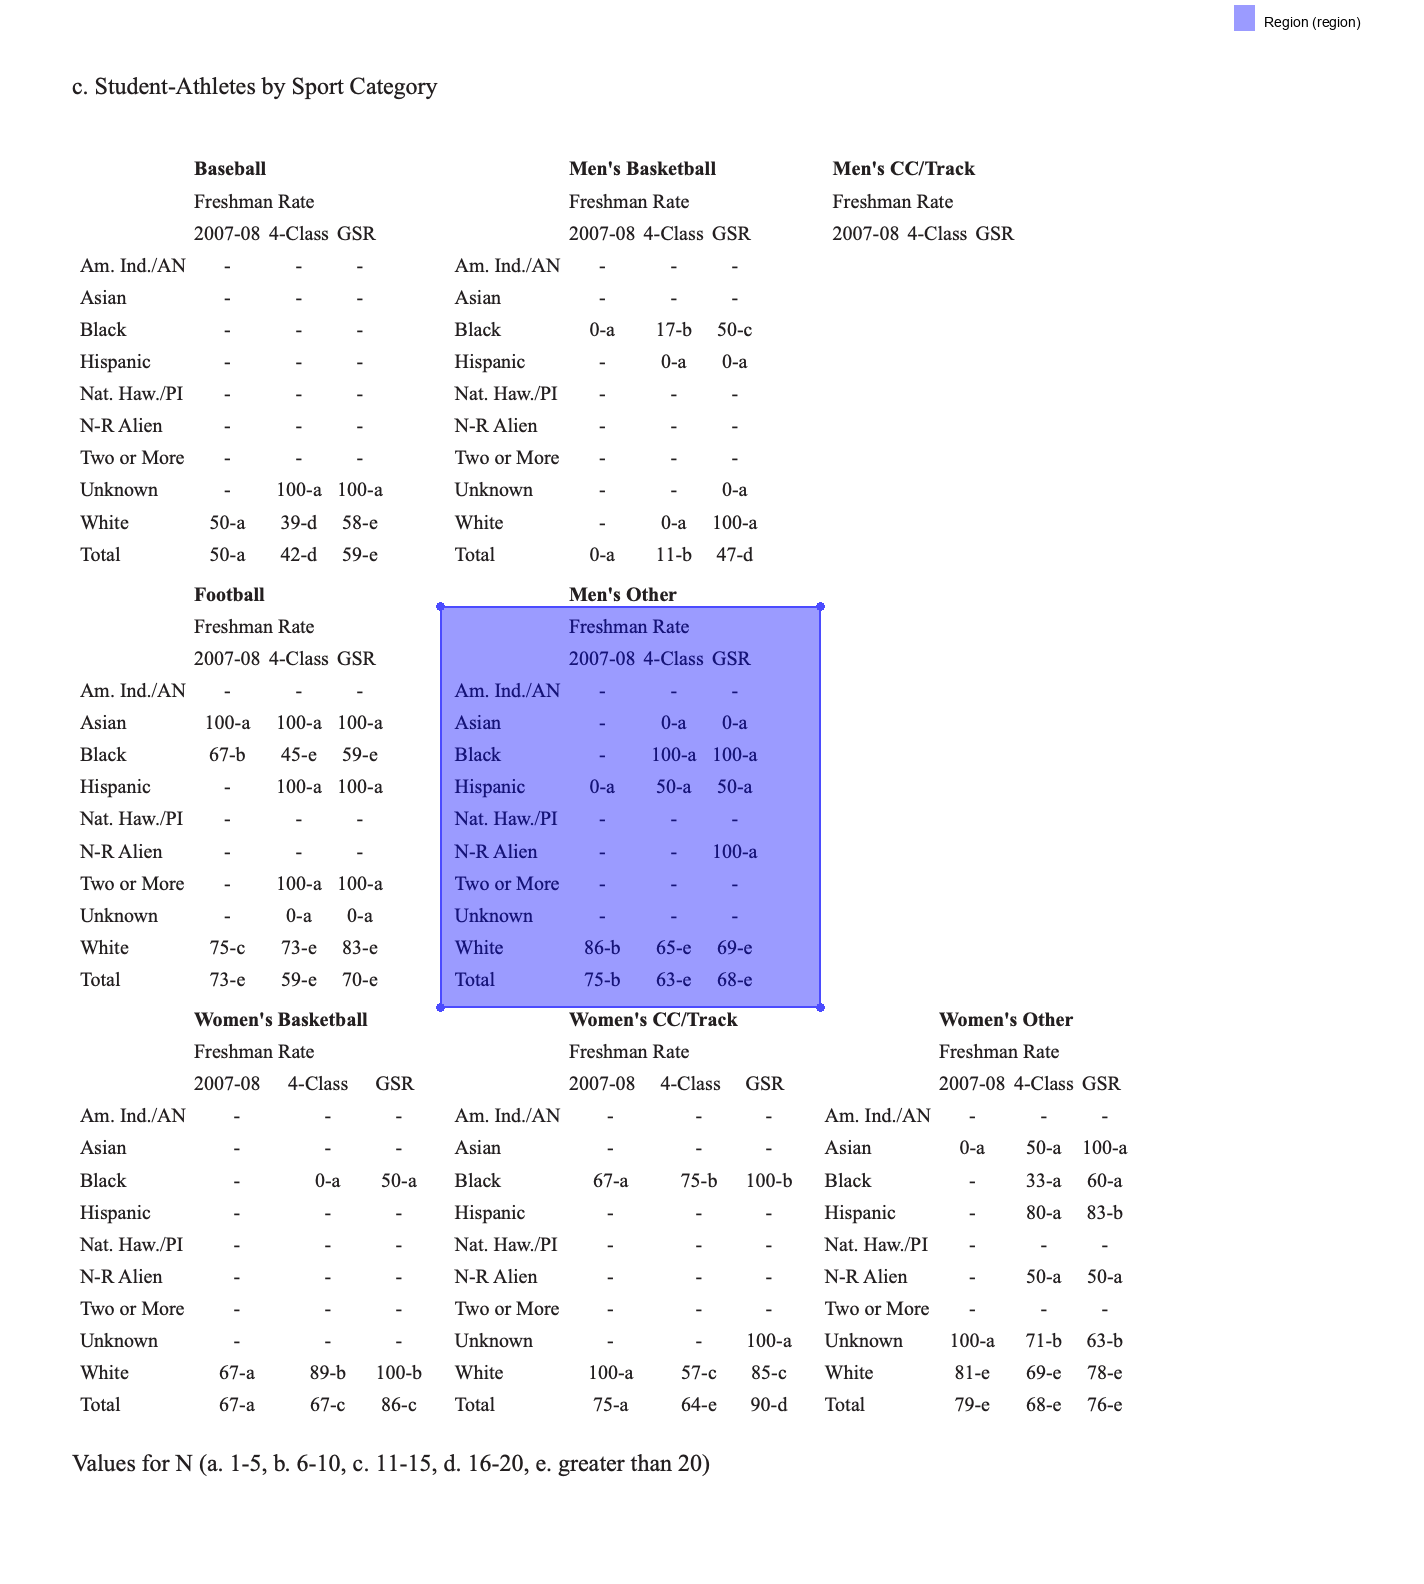

In [33]:
(
    page
    .find("text:contains(\"Men's Other\")")
    .below(
        until="text:contains(\"Women's CC\")",
        include_endpoint=False
    )
    .clip(left=220, right=410)
    .show()
)
#MenOther

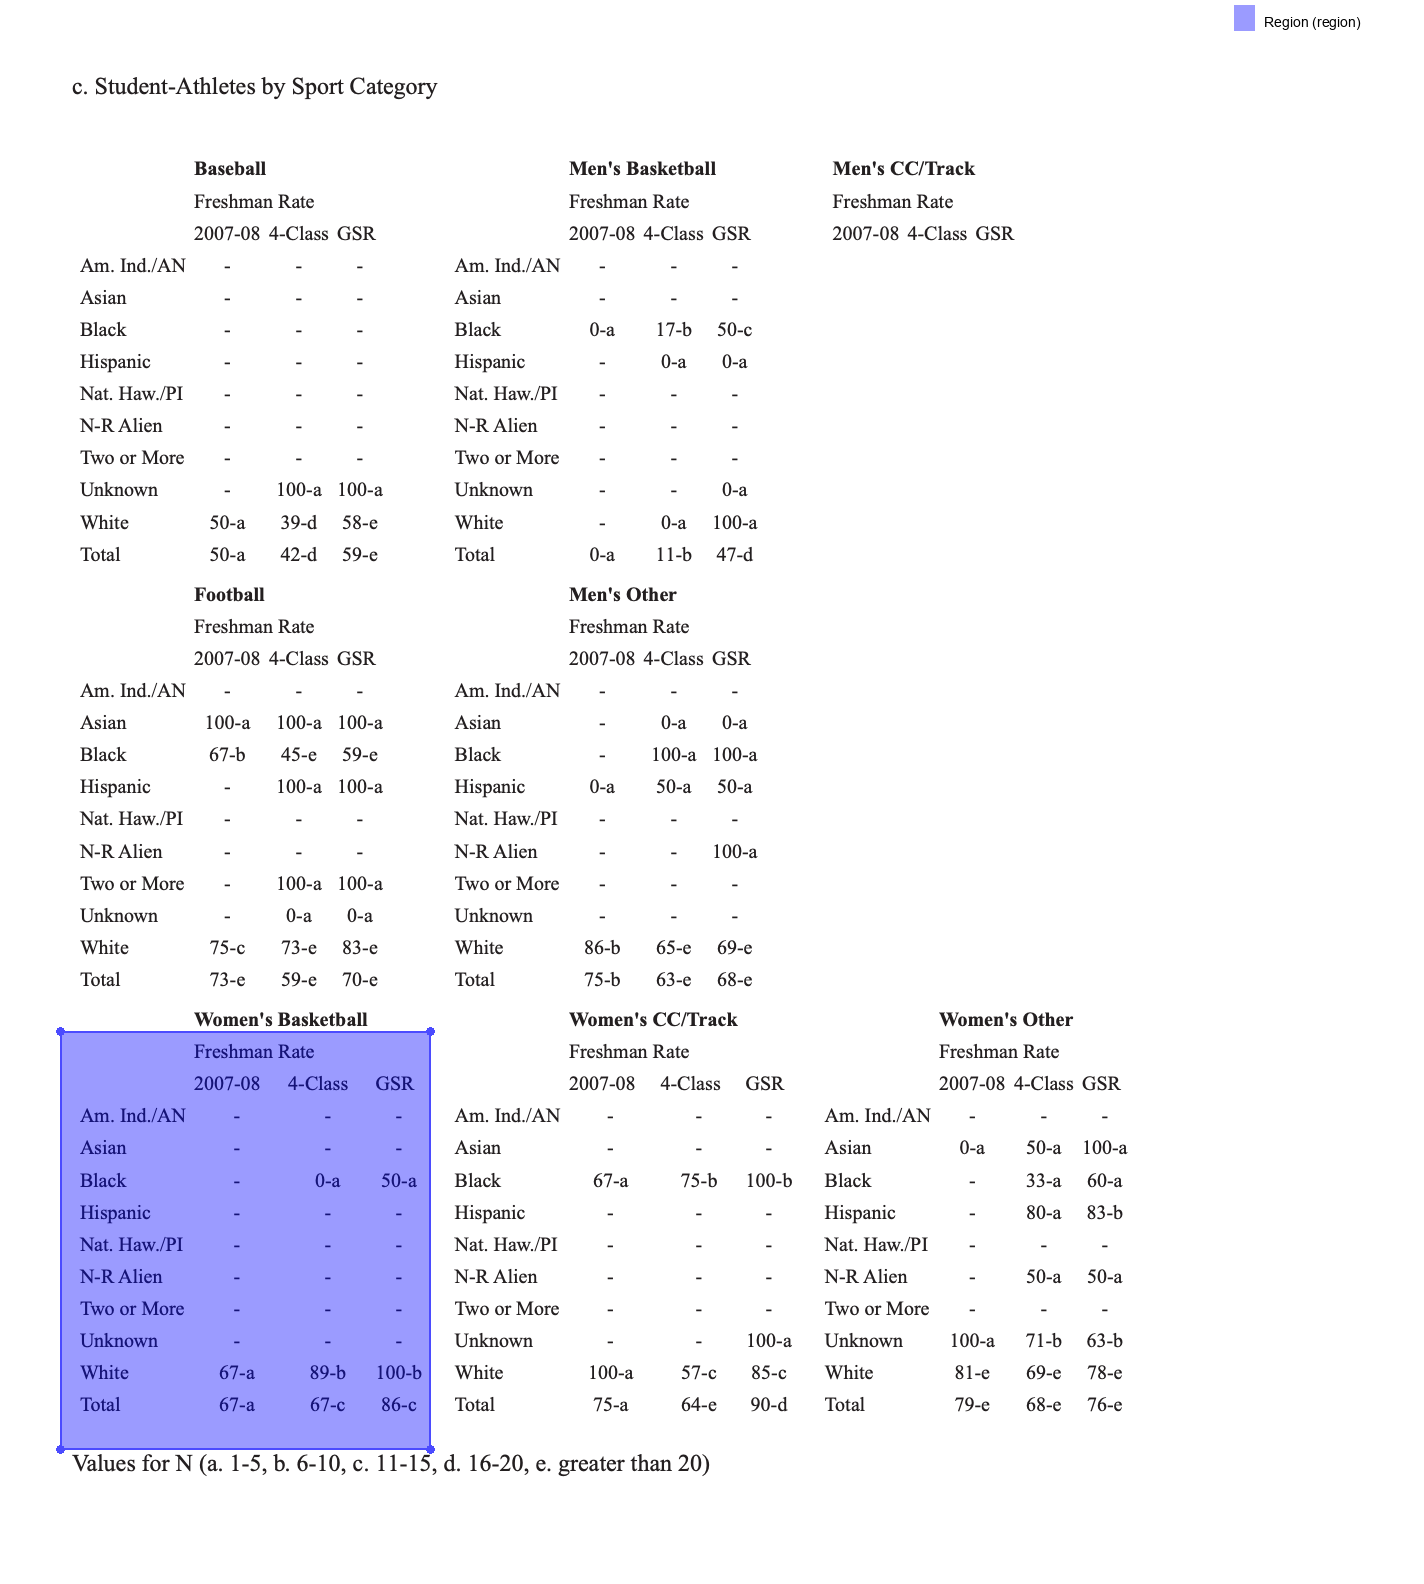

In [40]:


(
    page
    .find("text:contains(\"Women's Basketball\")")
    .below(
        until="text:contains(\"Values for N\")",
        include_endpoint=False
    )
    .clip(left=30, right=215)
    .show()
)
#WomenBasketball

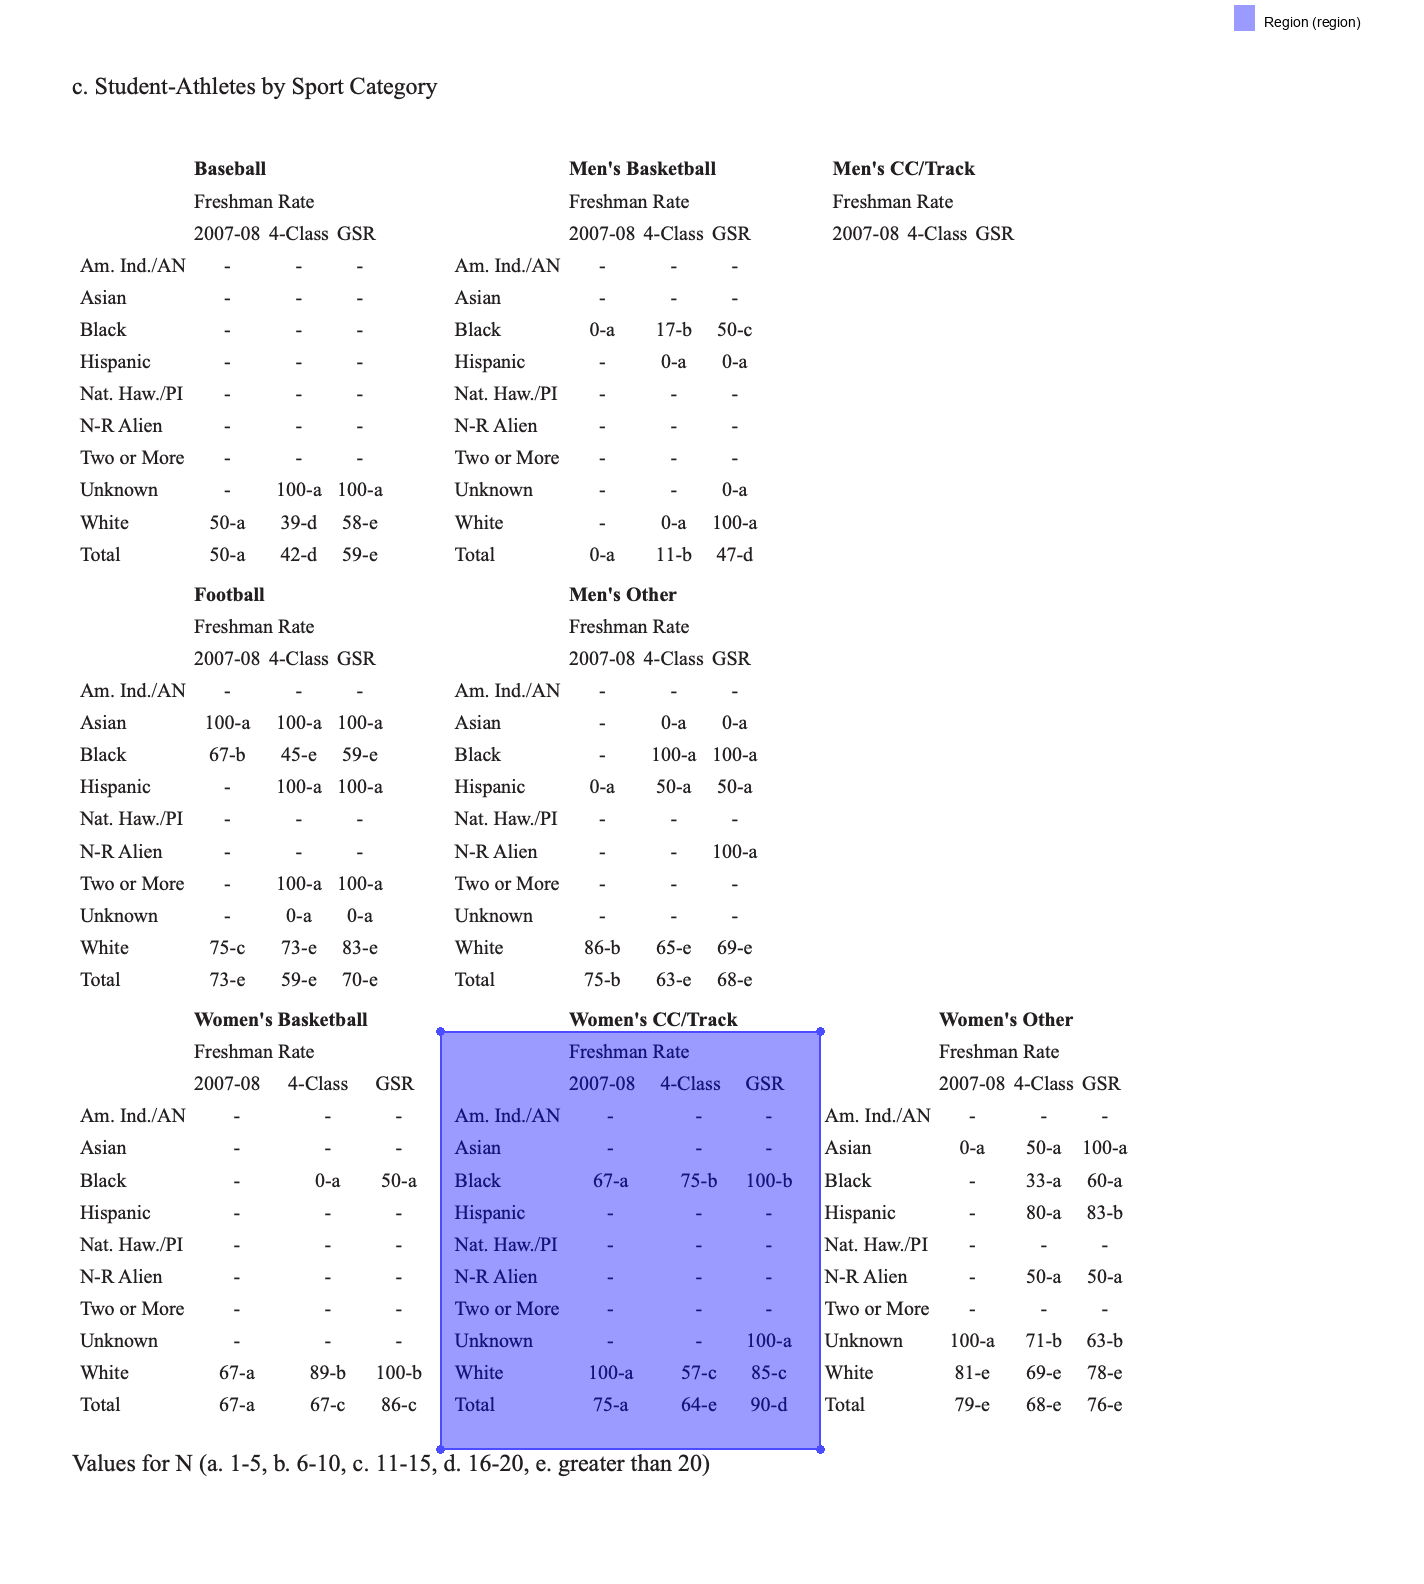

In [37]:
(
    page
    .find("text:contains(\"Women's CC\")")
    .below(
        until="text:contains(\"Values for N\")",
        include_endpoint=False
    )
    .clip(left=220, right=410)
    .show()
)
#WommenCC/Track

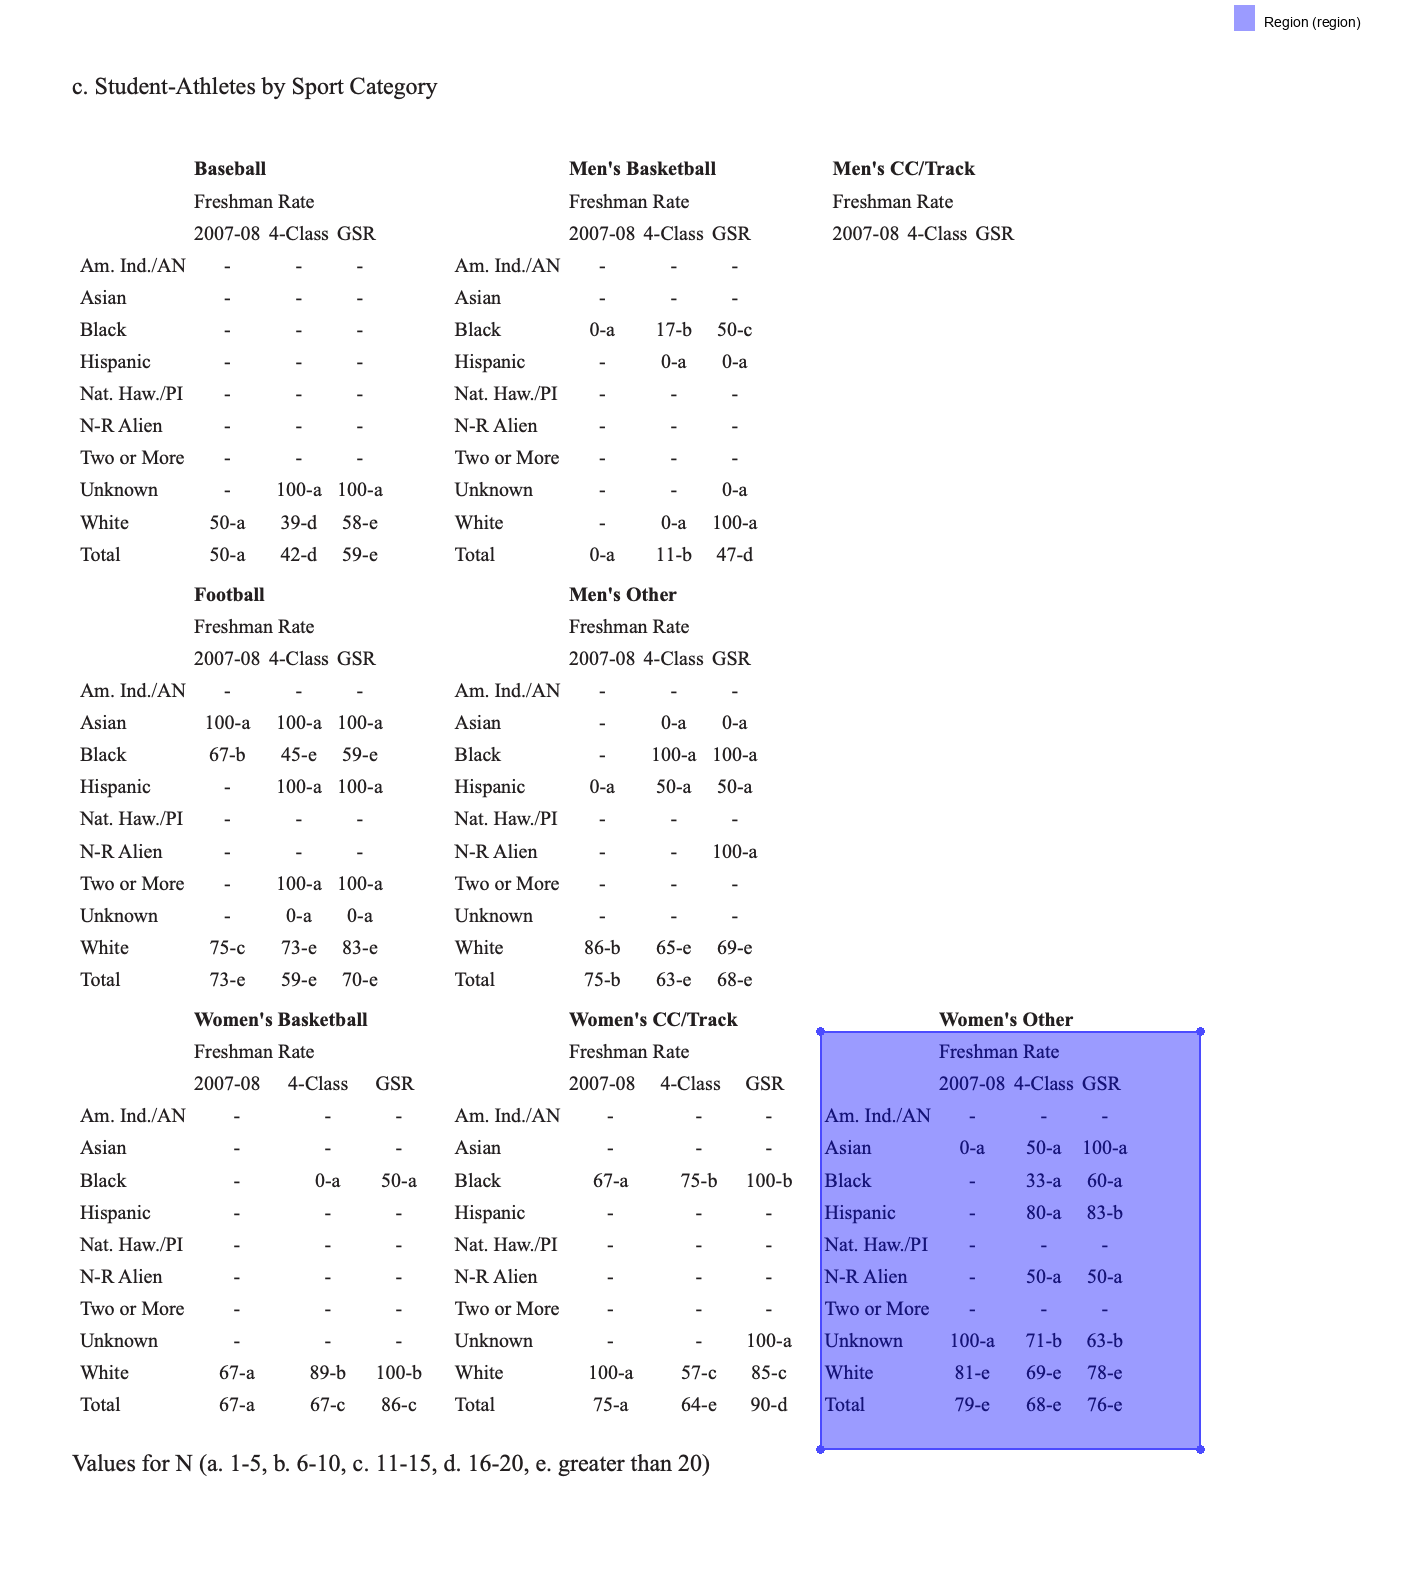

In [39]:
(
    page
    .find("text:contains(\"Women's Other\")")
    .below(
        until="text:contains(\"Values for N\")",
        include_endpoint=False
    )
    .clip(left=410, right=600)
    .show()
)
#WomenOther

In [2]:
import os

SPORT_CLIP_SETTINGS_2013 = {
    "Baseball": lambda page: (
        page.find("text:contains('Baseball')")
        .below(until="text:contains('Football')", include_endpoint=False)
        .clip(left=30, right=210)
    ),
    "Football": lambda page: (
        page.find("text:contains('Football')")
        .below(until="text:contains(\"Women's Basketball\")", include_endpoint=False)
        .clip(left=30, right=210)
    ),
    "Men's Basketball": lambda page: (
        page.find("text:contains(\"Men's Basketball\")")
        .below(until="text:contains(\"Men's Other\")", include_endpoint=False)
        .clip(left=220, right=410)
    ),
    "Men's Other": lambda page: (
        page.find("text:contains(\"Men's Other\")")
        .below(until="text:contains(\"Women's CC\")", include_endpoint=False)
        .clip(left=220, right=410)
    ),
    "Men's CC/Track": lambda page: (
        page.find("text:contains(\"Men's CC\")")
        .below(until="text:contains(\"Women's Other\")", include_endpoint=False)
        .clip(left=410, right=600)
    ),
    "Women's Basketball": lambda page: (
        page.find("text:contains(\"Women's Basketball\")")
        .below(until="text:contains(\"Values for N\")", include_endpoint=False)
        .clip(left=30, right=215)
    ),
    "Women's CC/Track": lambda page: (
        page.find("text:contains(\"Women's CC\")")
        .below(until="text:contains(\"Values for N\")", include_endpoint=False)
        .clip(left=220, right=410)
    ),
    "Women's Other": lambda page: (
        page.find("text:contains(\"Women's Other\")")
        .below(until="text:contains(\"Values for N\")", include_endpoint=False)
        .clip(left=410, right=600)
    ),
}

def extract_school_name(filename):
    return filename.replace(".pdf", "").replace("_", " ").strip()

def clean_row(row):
    return [cell.strip().replace("\xa0", " ") if isinstance(cell, str) else "" for cell in row]

def extract_all_sports_2013(pdf, school_name):
    page = pdf.pages[1]
    all_rows = []
    for sport, extractor in SPORT_CLIP_SETTINGS_2013.items():
        try:
            table = extractor(page).extract_table()
            if not table or len(table) < 2:
                continue
            for row in table:
                row = clean_row(row)
                row_padded = row[:5] + [""] * (5 - len(row))
                all_rows.append({
                    "School": school_name,
                    "Sport": sport,
                    "Race": row_padded[0],
                    "%N": row_padded[1],
                    "2013-14": row_padded[2],
                    "4-Class": row_padded[3],
                    "GSR": row_padded[4],
                })
        except Exception as e:
            print(f"{sport} failed for {school_name}: {e}")
    return all_rows

pdf_folder = "pdfs"
pdf_files = sorted([f for f in os.listdir(pdf_folder) if f.endswith(".pdf")])
all_data = []

for filename in pdf_files:
    school_name = extract_school_name(filename)
    filepath = os.path.join(pdf_folder, filename)
    try:
        pdf = PDF(filepath)
        if len(pdf.pages) < 2:
            print(f"Skipping {school_name} (too few pages)")
            continue
        data = extract_all_sports_2013(pdf, school_name)
        all_data.extend(data)
        print(f"Finished {school_name}")
    except Exception as e:
        print(f"Failed {school_name}: {e}")

df = pd.DataFrame(all_data)
df.to_csv("page2_all_sports_by_race_all_schools_2013.csv", index=False)
print("Saved to page2_all_sports_by_race_all_schools_2013.csv")

Finished Abilene Christian University
Finished Alabama A&M University
Finished Alabama State University
Finished Alcorn State University


KeyboardInterrupt: 